In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import netCDF4 as nc
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)
import cmocean as cm
import glob
from datetime import datetime, timedelta
import datetime as dt

## QIFS flowthrough lab pco2, T, S 

In [4]:
infil_GRL = np.loadtxt('./dir_from_Evans/QIFS_flow_through_lab_CO2')


yday = infil_GRL[:,0]
year = infil_GRL[:,1]
datenum = infil_GRL[:,2]
swpco2 = infil_GRL[:,20]
TSG_t = infil_GRL[:,4]
TSG_s = infil_GRL[:,5]

In [5]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    return datetime.fromordinal(int(datenum)) \
           + timedelta(days=int(days)) \
           + timedelta(hours=int(hours)) \
           + timedelta(minutes=int(minutes)) \
           + timedelta(seconds=round(seconds)) \
           - timedelta(days=366)

In [6]:

datelist = []

for i in range(0,len(datenum)):
    w = datenum_to_datetime(datenum[i])
    datelist.append(w) 



In [8]:
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
grid = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')
nav_lon = mesh.variables['nav_lon'][:]
nav_lat = mesh.variables['nav_lat'][:]
bathy = mesh.variables['Bathymetry'][:]
depth = grid.variables['gdept_1d'][:]


qifs_j, qifs_i = geo_tools.find_closest_model_point(-125.222,50.116,nav_lon,nav_lat)
print(qifs_j,qifs_i)

761 137


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(600.0, 800.0)

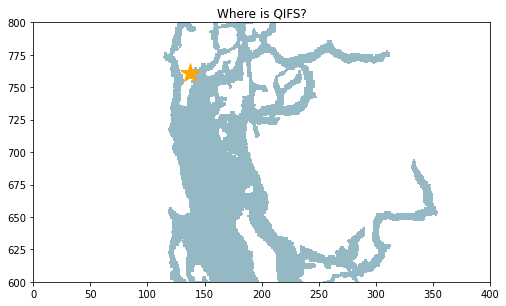

In [9]:


w = nc.Dataset('/data/tjarniko/results/hindcast.201905_dayavg_OmA-pH-pCO2/OmA_plus_20070104.nc')
pco2 = w['model_output']['pCO2'][:]
pco2[pco2>2e5] = np.nan
pco2[pco2<2000] = 500
fact = 1.5
fig = plt.figure(figsize=(12*fact,12*fact))

ax0 = fig.add_subplot(1,2,1)
#toba and bute

im = ax0.pcolormesh(pco2, cmap=cm.cm.balance_r, vmin = 0, vmax = 800)
viz_tools.set_aspect(ax0)

ax0.plot(137,761,markersize=20, marker = '*', color = 'orange')
ax0.set_title('Where is QIFS?')

ax0.set_xlim([0,400])
ax0.set_ylim([600,800])

In [10]:
# plt.rcParams.update({'font.size': 13})
# font = {'family' : 'normal',
# 'weight' : 'bold',
# 'size'   : 13}


# fact = 0.5
# fig, axs = plt.subplots(2,1, figsize=(20*fact, 11*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# axs[0].plot(datear,swpco2, color = 'orange',linestyle = '-')
# axs[0].plot(t_obs,co2_daily, color = 'black',linestyle = '-')
# axs[0].set_ylabel('$\mu$atm ')
# axs[1].plot(datear,TSG_t, color = 'r',linestyle = '-', label = 'temperature')
# axs[1].set_ylabel('temperature $\circ$C')
# axs1b = axs[1].twinx()
# axs1b.plot(datear, TSG_s, color = 'b', label = 'salinity (psu 78)')
# axs1b.set_ylabel('salinity (psu 78)')

# plt.suptitle('QIFS field station observations')


In [11]:
import pickle

t1 = datetime(2015,1,1,0,0,0)
t2 = datetime(2021,1,1,0,0,0)

t_mod = np.arange(t1, t2, timedelta(hours=1)).astype(datetime)
q = np.shape(t_mod)

In [12]:
date_doy = pickle.load(open("./pkls/date_doy.pkl", 'rb'))
DIC_doy = pickle.load(open("./pkls/DIC_doy.pkl", 'rb'))
TA_doy = pickle.load(open("./pkls/TA_doy.pkl", 'rb'))
temp_doy = pickle.load(open("./pkls/temp_doy.pkl", 'rb'))
sal_doy = pickle.load(open("./pkls/sal_doy.pkl", 'rb'))

In [13]:
import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy
import gsw

tzero = np.zeros_like(sal_doy)
tpressure = tzero+1
tsra_psu = sal_doy*35/35.16504
ttera_is = gsw.t_from_CT(sal_doy,temp_doy,tzero)
# for i in range(0,len(temp)):
    
#     ttera = temp[i]
#     ttera_is = gsw.t_from_CT(tsra,ttera,tzero)
response_tup = mocsy.mvars(temp=ttera_is, sal=tsra_psu, alk=TA_doy*1e-3, dic=DIC_doy*1e-3, 
                   sil=tzero, phos=tzero, patm=tpressure, depth=tzero, lat=tzero, 
                    optcon='mol/m3', optt='Tinsitu', optp='m',
                    optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2_mod,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
#print(pco2_mod)

/home/tjarniko/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.05, 'QIFS field station observations with SKOG model for comparison')

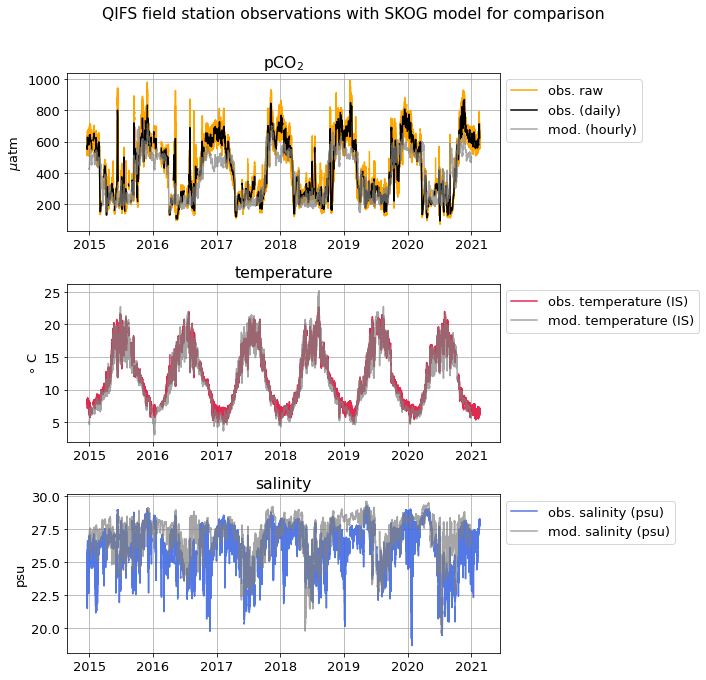

In [14]:
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 13}


fact = 0.5
fig, axs = plt.subplots(3,1, figsize=(20*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(datear,swpco2, color = 'orange',linestyle = '-', label =  'obs. raw')
co2_daily[co2_daily == 0] = np.nan
axs[0].plot(t_obs,co2_daily, color = 'black',linestyle = '-',label =  'obs. (daily)')
axs[0].plot(t_mod,pco2_mod, color = 'grey', alpha = 0.7, linestyle = '-', label = 'mod. (hourly)')
axs[0].set_ylabel('$\mu$atm '); axs[0].set_title('pCO$_2$')

axs[1].plot(datear,TSG_t, color = 'crimson', alpha = 0.9, linestyle = '-', label = 'obs. temperature (IS)')
axs[1].plot(t_mod,ttera_is, color = 'grey',alpha = 0.7, linestyle = '-', label = 'mod. temperature (IS)')
axs[1].set_ylabel('$\circ$ C'); axs[1].set_title('temperature')

axs[2].plot(datear,TSG_s, color = 'royalblue',alpha = 0.9, linestyle = '-', label = 'obs. salinity (psu)')
axs[2].plot(t_mod,tsra_psu, color = 'grey',alpha = 0.7, linestyle = '-', label = 'mod. salinity (psu)')
axs[2].set_ylabel('psu'); axs[2].set_title('salinity')

axs[0].legend(bbox_to_anchor = [1, 1])
axs[1].legend(bbox_to_anchor = [1, 1])
axs[2].legend(bbox_to_anchor = [1, 1])

for i in range(0,3):
    axs[i].grid()
plt.tight_layout()


plt.suptitle('QIFS field station observations with SKOG model for comparison', y= 1.05)


#### calculating daily timeseries means & pickling; cmmented out

In [30]:
# datear = np.array(datelist)
# print(np.shape(datelist))
# print(datelist[0])
# print(datelist[-1])

# t1 = datetime(2014,12,18,0,0,0)
# t2 = datetime(2021,2,19,0,0,0)

# t_obs = np.arange(t1, t2, timedelta(days=1)).astype(datetime)
# q = np.shape(t_obs)

# co2_daily = np.zeros(q[0])
# print(q)
# for i in range(0,q[0]-1):
#     #print(t[i])
#     tm = (datear >= t_obs[i]) &  (datear<t_obs[i+1])
#     #print(tm[tm==1].size)
#     tpco2 = swpco2[tm==1]
#     co2_daily[i] = (np.nanmean(tpco2))
    
# ## get daily average

# datear

# t1 = datetime(2014,12,18,0,0,0)
# t2 = datetime(2021,2,19,0,0,0)

# t_obs = np.arange(t1, t2, timedelta(days=1)).astype(datetime)
# q = np.shape(t_obs)

# obs_sal_daily = np.zeros(q[0])
# print(q)
# for i in range(0,q[0]-1):
#     tm = (datear >= t_obs[i]) &  (datear<t_obs[i+1])
#     tpco2 = TSG_s[tm==1]
#     obs_sal_daily[i] = (np.nanmean(tpco2))
    
    
# mod_sal_daily = np.zeros(q[0])
# print(q)
# for i in range(0,q[0]-1):
#     #t_mod,tsra_psu
#     tm = (t_mod >= t_obs[i]) &  (t_mod<t_obs[i+1])
#     tpco2 = tsra_psu[tm==1]
#     mod_sal_daily[i] = (np.nanmean(tpco2))
    
# print('done')

# ## get daily average

# datear

# t1 = datetime(2014,12,18,0,0,0)
# t2 = datetime(2021,2,19,0,0,0)

# t_obs = np.arange(t1, t2, timedelta(days=1)).astype(datetime)
# q = np.shape(t_obs)

# obs_temp_daily = np.zeros(q[0])
# print(q)
# for i in range(0,q[0]-1):
#     tm = (datear >= t_obs[i]) &  (datear<t_obs[i+1])
#     tpco2 = TSG_t[tm==1]
#     obs_temp_daily[i] = (np.nanmean(tpco2))
    
    
# mod_temp_daily = np.zeros(q[0])
# print(q)
# for i in range(0,q[0]-1):
#     #t_mod,tsra_psu
#     tm = (t_mod >= t_obs[i]) &  (t_mod<t_obs[i+1])
#     tpco2 = ttera_is[tm==1]
#     mod_temp_daily[i] = (np.nanmean(tpco2))
    
# print('done')

# pco2_mod

# datear

# t1 = datetime(2014,12,18,0,0,0)
# t2 = datetime(2021,2,19,0,0,0)

# t_obs = np.arange(t1, t2, timedelta(days=1)).astype(datetime)
# q = np.shape(t_obs)
    
# mod_co2_daily = np.zeros(q[0])
# print(q)
# for i in range(0,q[0]-1):
#     #t_mod,tsra_psu
#     tm = (t_mod >= t_obs[i]) &  (t_mod<t_obs[i+1])
#     tpco2 = pco2_mod[tm==1]
#     mod_co2_daily[i] = (np.nanmean(tpco2))
    
# print('done')

# obs_co2_daily = co2_daily

# pickle.dump(obs_co2_daily, open("./pkls/obs_co2_daily.pkl", 'wb'))
# pickle.dump(mod_co2_daily, open("./pkls/mod_co2_daily.pkl", 'wb'))
# pickle.dump(obs_sal_daily, open("./pkls/obs_sal_daily.pkl", 'wb'))
# pickle.dump(mod_sal_daily, open("./pkls/mod_sal_daily.pkl", 'wb'))
# pickle.dump(obs_temp_daily, open("./pkls/obs_temp_daily.pkl", 'wb'))
# pickle.dump(mod_temp_daily, open("./pkls/mod_temp_daily.pkl", 'wb'))

(575394,)
2014-12-18 22:31:09
2021-02-18 14:46:10
(2255,)


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


(2255,)


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


(2255,)


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice


done
(2255,)


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: Mean of empty slice


(2255,)


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: Mean of empty slice


done
(2255,)


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice


done


In [32]:
obs_co2_daily = pickle.load(open('./pkls/obs_co2_daily.pkl', 'rb'))  
mod_co2_daily = pickle.load(open('./pkls/mod_co2_daily.pkl', 'rb'))  
obs_sal_daily = pickle.load(open('./pkls/obs_sal_daily.pkl', 'rb'))  
mod_sal_daily = pickle.load(open('./pkls/mod_sal_daily.pkl', 'rb'))  
obs_temp_daily = pickle.load(open('./pkls/obs_temp_daily.pkl', 'rb'))  
mod_temp_daily = pickle.load(open('./pkls/mod_temp_daily.pkl', 'rb'))  

(2255,)


In [17]:
tobs_month = np.zeros_like(mod_sal_daily)

for i in range(0,len(tobs_month)):
    tw = t_obs[i]
    tobs_month[i] = tw.month 

/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


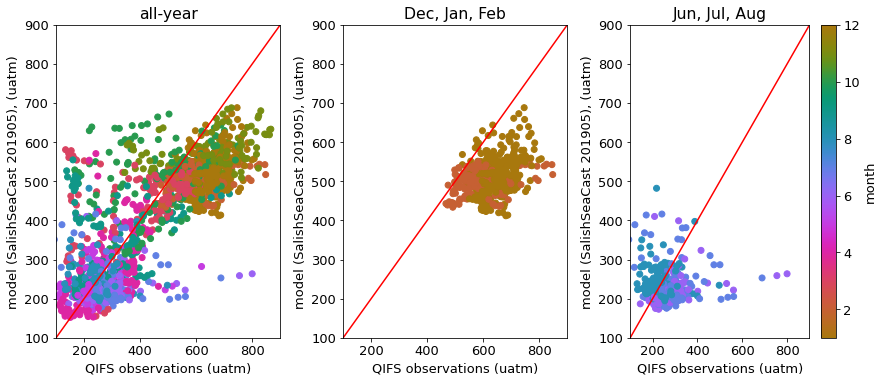

In [60]:
xlo = 100; xhi = 900; 
ylo = 100; yhi = 900; 

obs_co2_daily[obs_co2_daily<2] = np.nan
mod_co2_daily[mod_co2_daily<2] = np.nan
fact = 0.5
fig, axs = plt.subplots(1,3, figsize=(25*fact, 11*fact),\
                        facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].scatter(obs_co2_daily,mod_co2_daily,c = tobs_month, cmap = cm.cm.phase)
axs[0].set_title('all-year')

mask = (tobs_month < 3) | (tobs_month > 11)
axs[1].scatter(obs_co2_daily[mask],mod_co2_daily[mask],c = tobs_month[mask], cmap = cm.cm.phase, \
               vmin = 1, vmax = 12)
axs[1].set_title('Dec, Jan, Feb')

mask = (tobs_month >5) & (tobs_month < 9)
axs[2].scatter(obs_co2_daily[mask],mod_co2_daily[mask],c = tobs_month[mask], cmap = cm.cm.phase, \
               vmin = 1, vmax = 12)
axs[2].set_title('Jun, Jul, Aug')

for i in range(0,3):
    
    axs[i].plot([xlo,yhi],[ylo,yhi],'r-')
    axs[i].set_xlim([xlo,xhi])
    axs[i].set_ylim([ylo,yhi])
    axs[i].set_xlabel('QIFS observations (uatm)')
    axs[i].set_ylabel('model (SalishSeaCast 201905), (uatm)')
    
plt.colorbar(w, label = 'month')
plt.tight_layout()


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


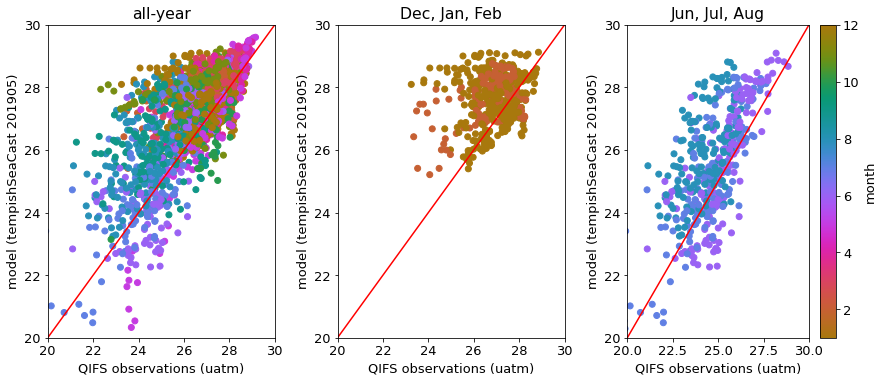

In [61]:
xlo = 20; xhi = 30; 
ylo = 20; yhi = 30; 

obs_sal_daily[obs_sal_daily<2] = np.nan
mod_sal_daily[mod_sal_daily<2] = np.nan
fact = 0.5
fig, axs = plt.subplots(1,3, figsize=(25*fact, 11*fact),\
                        facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].scatter(obs_sal_daily,mod_sal_daily,c = tobs_month, cmap = cm.cm.phase)
axs[0].set_title('all-year')

mask = (tobs_month < 3) | (tobs_month > 11)
axs[1].scatter(obs_sal_daily[mask],mod_sal_daily[mask],c = tobs_month[mask], cmap = cm.cm.phase, \
               vmin = 1, vmax = 12)
axs[1].set_title('Dec, Jan, Feb')

mask = (tobs_month >5) & (tobs_month < 9)
axs[2].scatter(obs_sal_daily[mask],mod_sal_daily[mask],c = tobs_month[mask], cmap = cm.cm.phase, \
               vmin = 1, vmax = 12)
axs[2].set_title('Jun, Jul, Aug')

for i in range(0,3):
    
    axs[i].plot([xlo,yhi],[ylo,yhi],'r-')
    axs[i].set_xlim([xlo,xhi])
    axs[i].set_ylim([ylo,yhi])
    axs[i].set_xlabel('QIFS observations (psu)')
    axs[i].set_ylabel('model (SSC 201905) (psu)')
    
plt.colorbar(w, label = 'month')
plt.tight_layout()


##### 

/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


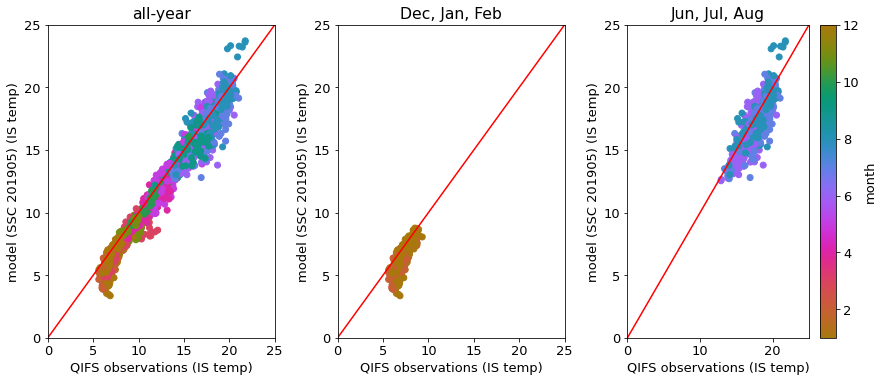

In [90]:
xlo = 0; xhi = 25; 
ylo = 0; yhi = 25; 

obs_temp_daily[obs_temp_daily<2] = np.nan
mod_temp_daily[mod_temp_daily<2] = np.nan
fact = 0.5
fig, axs = plt.subplots(1,3, figsize=(25*fact, 11*fact),\
                        facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].scatter(obs_temp_daily,mod_temp_daily,c = tobs_month, cmap = cm.cm.phase)
axs[0].set_title('all-year')

mask = (tobs_month < 3) | (tobs_month > 11)
axs[1].scatter(obs_temp_daily[mask],mod_temp_daily[mask],c = tobs_month[mask], cmap = cm.cm.phase, \
               vmin = 1, vmax = 12)
axs[1].set_title('Dec, Jan, Feb')

mask = (tobs_month >5) & (tobs_month < 9)
axs[2].scatter(obs_temp_daily[mask],mod_temp_daily[mask],c = tobs_month[mask], cmap = cm.cm.phase, \
               vmin = 1, vmax = 12)
axs[2].set_title('Jun, Jul, Aug')

for i in range(0,3):
    
    axs[i].plot([xlo,yhi],[ylo,yhi],'r-')
    axs[i].set_xlim([xlo,xhi])
    axs[i].set_ylim([ylo,yhi])
    axs[i].set_xlabel('QIFS observations (IS temp)')
    axs[i].set_ylabel('model (SSC 201905) (IS temp)')
    
plt.colorbar(w, label = 'month')
plt.tight_layout()


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


Text(0.5, 1.05, 'pco2 vs salinity')

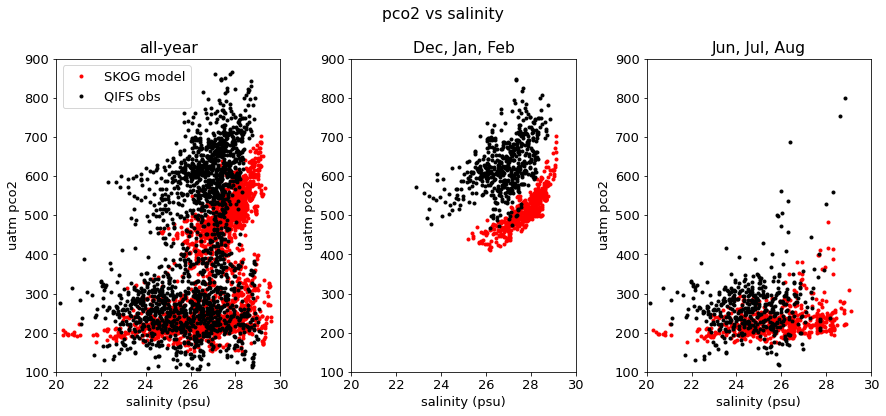

In [84]:
xlo = 20; xhi = 30; 
ylo = 100; yhi = 900; 

obs_co2_daily[obs_co2_daily<2] = np.nan
mod_co2_daily[mod_co2_daily<2] = np.nan
fact = 0.5
fig, axs = plt.subplots(1,3, figsize=(25*fact, 11*fact),\
                        facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(mod_sal_daily,mod_co2_daily,'r.', label = 'SKOG model')
axs[0].plot(obs_sal_daily,obs_co2_daily,'k.', label = 'QIFS obs')
axs[0].set_xlabel('salinity (psu)')
axs[0].set_ylabel('model (salishSeaCast 201905)')
axs[0].set_title('all-year')

mask = (tobs_month < 3) | (tobs_month > 11)
axs[1].plot(mod_sal_daily[mask],mod_co2_daily[mask],'r.', label = 'SKOG model')
axs[1].plot(obs_sal_daily[mask],obs_co2_daily[mask],'k.', label = 'QIFS obs')

axs[1].set_ylabel('model (salishSeaCast 201905)')
axs[1].set_title('Dec, Jan, Feb')

mask = (tobs_month >5) & (tobs_month < 9)
axs[2].plot(mod_sal_daily[mask],mod_co2_daily[mask],'r.', label = 'SKOG model')
axs[2].plot(obs_sal_daily[mask],obs_co2_daily[mask],'k.', label = 'QIFS obs')


axs[2].set_title('Jun, Jul, Aug')

for i in range(0,3):
    axs[i].set_xlabel('salinity (psu)')
    axs[i].set_ylabel('uatm pco2')
    axs[i].set_xlim([xlo,xhi])
    axs[i].set_ylim([ylo,yhi])
    
axs[0].legend(loc = 'best')
plt.tight_layout()
plt.suptitle('pco2 vs salinity', y = 1.05)

536.3074529407944
-447.0241082768396


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.05, 'mod. vs obs. salinity coloured by pco2')

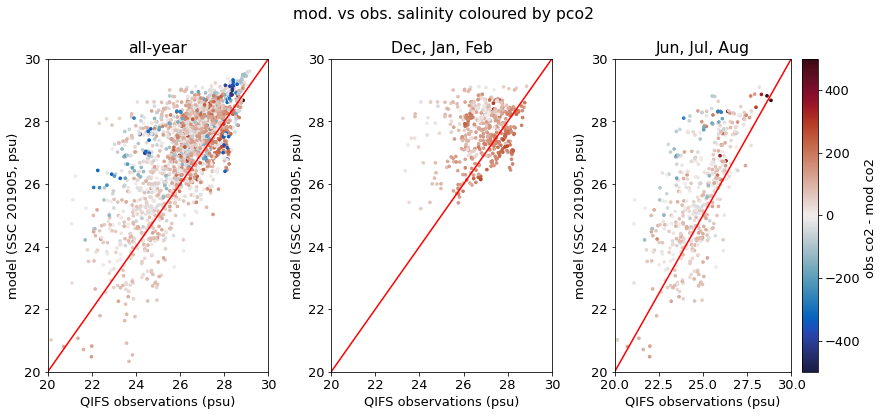

In [86]:
co2diff = obs_co2_daily-mod_co2_daily
print(np.nanmax(co2diff))
print(np.nanmin(co2diff))

ts = 7
xlo = 20; xhi = 30; 
ylo = 20; yhi = 30; 

obs_sal_daily[obs_sal_daily<2] = np.nan
mod_sal_daily[mod_sal_daily<2] = np.nan
fact = 0.5
fig, axs = plt.subplots(1,3, figsize=(25*fact, 11*fact),\
                        facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].scatter(obs_sal_daily,mod_sal_daily,c = co2diff, s= ts, cmap = cm.cm.balance, vmin = -500, vmax = 500)
axs[0].set_title('all-year')

mask = (tobs_month < 3) | (tobs_month > 11)
axs[1].scatter(obs_sal_daily[mask],mod_sal_daily[mask],c = co2diff[mask], s= ts, cmap = cm.cm.balance, \
               vmin = -500, vmax = 500)
axs[1].set_title('Dec, Jan, Feb')

mask = (tobs_month >5) & (tobs_month < 9)
axs[2].scatter(obs_sal_daily[mask],mod_sal_daily[mask],c = co2diff[mask], s= ts, cmap = cm.cm.balance, \
               vmin = -500, vmax = 500)
axs[2].set_title('Jun, Jul, Aug')

for i in range(0,3):
    
    axs[i].plot([xlo,yhi],[ylo,yhi],'r-')
    axs[i].set_xlim([xlo,xhi])
    axs[i].set_ylim([ylo,yhi])
    axs[i].set_xlabel('QIFS observations (psu)')
    axs[i].set_ylabel('model (SSC 201905, psu)')
    
plt.colorbar(w, label = 'obs co2 - mod co2 ')
plt.tight_layout()
plt.suptitle('mod. vs obs. salinity coloured by pco2', y = 1.05)



536.3074529407944
-447.0241082768396


/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/tjarniko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.05, 'pco2 difference (OBS-MOD) vs salinity difference (MOD-OBS)')

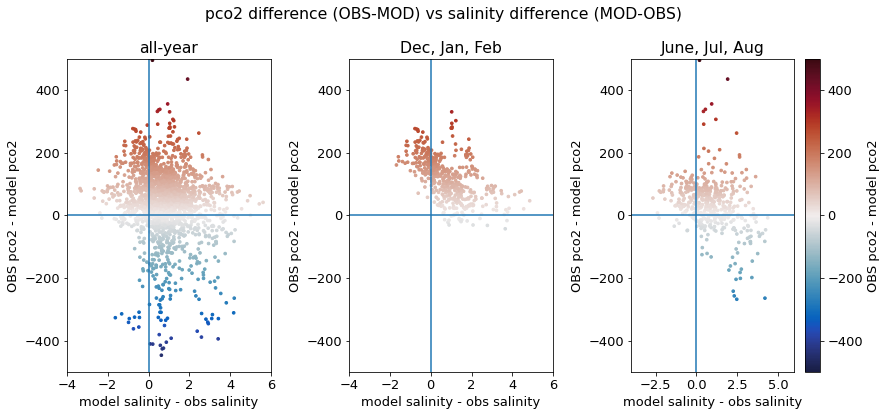

In [89]:
co2diff = obs_co2_daily-mod_co2_daily
print(np.nanmax(co2diff))
print(np.nanmin(co2diff))

ts = 7
xlo = -4; xhi = 6; 
ylo = -500; yhi = 500; 

obs_sal_daily[obs_sal_daily<2] = np.nan
mod_sal_daily[mod_sal_daily<2] = np.nan
fact = 0.5
fig, axs = plt.subplots(1,3, figsize=(25*fact, 11*fact),\
                        facecolor='w', edgecolor='k')
axs = axs.ravel()

w = axs[0].scatter(mod_sal_daily-obs_sal_daily,co2diff,c = co2diff, s= ts, cmap = cm.cm.balance, vmin = -500, vmax = 500)
axs[0].set_title('all-year')

mask = (tobs_month < 3) | (tobs_month > 11)
w = axs[1].scatter(mod_sal_daily[mask]-obs_sal_daily[mask],co2diff[mask],c = co2diff[mask], \
                   s= ts, cmap = cm.cm.balance, vmin = -500, vmax = 500)
axs[1].set_title('Dec, Jan, Feb')

mask = (tobs_month >5) & (tobs_month < 9)
w = axs[2].scatter(mod_sal_daily[mask]-obs_sal_daily[mask],co2diff[mask],c = co2diff[mask], \
                   s= ts, cmap = cm.cm.balance, vmin = -500, vmax = 500)
axs[2].set_title('June, Jul, Aug')

for i in range(0,3):
    
#    axs[i].plot([xlo,yhi],[ylo,yhi],'r-')
    axs[i].set_xlim([xlo,xhi])
    axs[i].set_ylim([ylo,yhi])
    axs[i].set_xlabel('model salinity - obs salinity')
    axs[i].set_ylabel('OBS pco2 - model pco2')
    axs[i].axhline(y=0)
    axs[i].axvline(x=0)
plt.colorbar(w, label = 'OBS pco2 - model pco2')
plt.tight_layout()
plt.suptitle('pco2 difference (OBS-MOD) vs salinity difference (MOD-OBS)', y = 1.05)
